In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
INPUT_SIZE = 2
HIDDEN_SIZE = 128
NUM_LAYERS = 8
LR = 0.001
EPOCH = 12
SEQUENCE_NUMBER = 2
BATCH_SIZE = 32

# Preparing Data

In [ ]:
data = pd.read_csv('../data/REMEDY.HE.csv')
data = data.drop(columns=['Adj Close']) 
data.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-02,11.65,12.30,11.65,11.80,20521
1,2020-01-03,12.05,12.05,11.45,11.80,9241
2,2020-01-07,11.80,12.10,11.80,11.95,7571
3,2020-01-08,11.90,12.20,11.80,12.10,15467
4,2020-01-09,12.15,12.70,12.15,12.50,19329


# Preprocessing

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
# We can Drop `Open`, `High`, `Low` , the all follow the same shape and distribution as `Close`, and it can cause problems
data.drop(columns=['Open', 'High', 'Low'], inplace=True)

### Scaling

In [ ]:
# scaling
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

data[['Close']] = min_max_scaler.fit_transform(data[['Close']])
data['Volume'] = min_max_scaler.fit_transform(data[['Volume']])

### Other

In [ ]:
# we don't need the dates 
data.drop(columns=['Date'], inplace=True)

In [ ]:
# split to train and test
train_size = int(len(data)*0.85)
train = data.iloc[:train_size, :]
test = data.iloc[train_size:, :]

In [ ]:
data.head()

,Close,Volume
0,0.035851,0.080253
1,0.035851,0.034701
2,0.039693,0.027957
3,0.043534,0.059843
4,0.053777,0.075439


In [ ]:
train

,Close,Volume
0,0.035851,0.080253
1,0.035851,0.034701
2,0.039693,0.027957
3,0.043534,0.059843
4,0.053777,0.075439
...,...,...
876,0.361076,0.003166
877,0.361076,0.007309
878,0.368758,0.003994
879,0.357234,0.001373


### Making Sequence

In [ ]:
class MakeSequence(Dataset):
    def __init__(self, data, sequence_length, target):
        self.target_column_number = np.where(data.columns == target)[0][0]
        self.target = target
        self.sequence_length = sequence_length
        self.data = data.values
        self.x, self.y = self._transform()

    def _transform(self):
        x = self._make_sequence()
        y = self._make_y(x)
        # Remove the last input sequence as it has no corresponding target
        x = x[:-1]
        return x, y

    def _make_sequence(self):
        sequenced_data = np.lib.stride_tricks.sliding_window_view(self.data, window_shape=(self.sequence_length, self.data.shape[1]))
        sequenced_data = np.squeeze(sequenced_data)
        return sequenced_data
    
    def _make_y(self, x):
        return x[1:, :, self.target_column_number]

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index], dtype=torch.float)
        y = torch.tensor(self.y[index], dtype=torch.float)
        return x, y

In [ ]:
train_data = MakeSequence(train, SEQUENCE_NUMBER, target='Close')
test_data = MakeSequence(test, SEQUENCE_NUMBER, target='Close')

In [ ]:
# dataloader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, # ! set it to True, the results become pretty good!
    drop_last=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)

# Modeling

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x, h_0, c_0):
        '''
            x : input X data 
            h_0 : hidden state (short-term memory)
            c_0 : cell state (long-term memory)
        '''
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.linear(output[:, -1, :])
        return output, (h_n, c_n)

To make sure you are inputting the right data shape into the model, checkout <a href='https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html'> torch </a> docs about LSTM input dims :  


In [ ]:
model = LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train loop
train_loss_values = []
test_loss_values = []
for epoch in range(EPOCH):
    train_batch_loss_values = 0
    model.train()
    for batch, (x, y) in enumerate(train_dataloader):
        # x shape -> (BATCH_SIZE, SEQUENCE_LENGTH, INPUT_SIZE)
        # x = x.permute(1, 0).unsqueeze(dim=0) 
        x = x.to(device)
        y = y.to(device)

        h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        output, (h_n, c_n) = model(x, h_0, c_0)
        loss = criterion(output.squeeze(dim=0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_batch_loss_values += loss.item()

    # evaluate on test dataset
    model.eval()
    test_batch_loss_values = 0
    with torch.inference_mode():
        for x, y in test_dataloader:
            # x = x.permute(1, 0).unsqueeze(dim=0)
            x = x.to(device)
            y = y.to(device)
            h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
            c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
            output, (h_n, c_n) = model(x, h_0, c_0)
            loss = criterion(output.squeeze(dim=0), y)
            test_batch_loss_values += loss.item()

    train_loss_values.append(train_batch_loss_values / (batch+1))
    test_loss_values.append(test_batch_loss_values / (batch+1))
    print("EPOCH:", epoch)
    print("train-loss: {0:.6f}".format(train_loss_values[epoch]))
    print("test-loss: {0:.6f}".format(test_loss_values[epoch]))

/opt/miniconda3/envs/dl2/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


EPOCH: 0
train-loss: 0.085270
test-loss: 0.005271
EPOCH: 1
train-loss: 0.031319
test-loss: 0.001260
EPOCH: 2
train-loss: 0.014079
test-loss: 0.000397
EPOCH: 3
train-loss: 0.001317
test-loss: 0.000026
EPOCH: 4
train-loss: 0.000403
test-loss: 0.000026
EPOCH: 5
train-loss: 0.000312
test-loss: 0.000025
EPOCH: 6
train-loss: 0.000335
test-loss: 0.000031
EPOCH: 7
train-loss: 0.000306
test-loss: 0.000030
EPOCH: 8
train-loss: 0.000301
test-loss: 0.000030
EPOCH: 9
train-loss: 0.000324
test-loss: 0.000030
EPOCH: 10
train-loss: 0.000368
test-loss: 0.000031
EPOCH: 11
train-loss: 0.000342
test-loss: 0.000033


# Evaluation

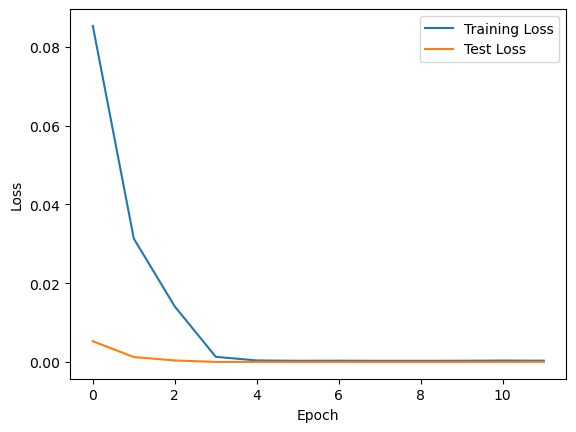

In [ ]:
# plot the losses
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_close = [y[:, 0].cpu().numpy() for x, y in test_dataloader]
test_close = np.concatenate(test_close)

In [ ]:
model.eval()
test_predictions = []
with torch.inference_mode():
    for x, y in test_dataloader:
        x = x.to(device)
        h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        output, (h_n, c_n) = model(x, h_0, c_0)
        test_predictions.extend(output.squeeze(dim=0).cpu().numpy())


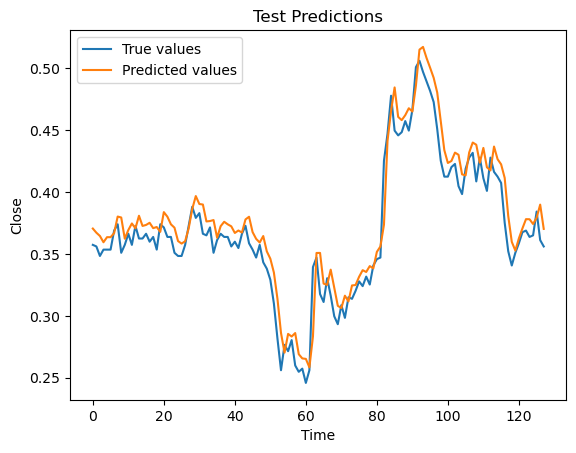

In [ ]:
plt.plot(test_close, label='True values')
plt.plot(test_predictions, label='Predicted values')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('Test Predictions')
plt.legend()
plt.show()


In [ ]:
# !jupyter nbconvert --to script main.ipynb

___

# 2

In [6]:
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.pipeline import Pipeline

from src.utils.pipelines import DropColumns, Scaler, SequencePipeline
from src.utils.train_test_split import train_test_split
from src.models.LSTM import LSTM
from src.train import train
from src.eval import eval

In [7]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

def preprocess():
    preprocess_pipeline = Pipeline([
        ('drop_columns', DropColumns(['Open', 'High', 'Low', 'Adj Close', 'Date'])),
        ('scale_close', Scaler(feature='Close')),
        ('scale_volume', Scaler(feature='Volume')),
        ('make_sequence', SequencePipeline(sequence_length=SEQUENCE_NUMBER, target='Close'))
    ])
    # load and preprocess
    data = pd.read_csv('../data/REMEDY.HE.csv')
    train, test = train_test_split(data, train_size_split=0.85)
    train_data = preprocess_pipeline.fit_transform(train)
    test_data = preprocess_pipeline.fit_transform(test)

    # dataloader
    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True, # ! setting it to True, the results become pretty good!
        drop_last=True,
    )
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=True,
    )

    return train_dataloader, test_dataloader


train_dataloader, test_dataloader = preprocess()

model = LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, batch_size=BATCH_SIZE).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loss_values = list()
test_loss_values = list()
for epoch in range(EPOCH):
    train_loss = train(model, criterion, optimizer, train_dataloader, device=device)
    test_loss = eval(model, criterion, test_dataloader, device=device)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    print("EPOCH:", epoch)
    print("train-loss: {0:.6f}".format(train_loss_values[epoch]))
    print("test-loss: {0:.6f}".format(test_loss_values[epoch]))


/opt/miniconda3/envs/dl2/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


EPOCH: 0
train-loss: 0.093192
test-loss: 0.016378
EPOCH: 1
train-loss: 0.031219
test-loss: 0.014820
EPOCH: 2
train-loss: 0.022385
test-loss: 0.005796
EPOCH: 3
train-loss: 0.002176
test-loss: 0.002118
EPOCH: 4
train-loss: 0.000454
test-loss: 0.001713
EPOCH: 5
train-loss: 0.000334
test-loss: 0.001649
EPOCH: 6
train-loss: 0.000307
test-loss: 0.001636
EPOCH: 7
train-loss: 0.000297
test-loss: 0.001644
EPOCH: 8
train-loss: 0.000296
test-loss: 0.001729
EPOCH: 9
train-loss: 0.000314
test-loss: 0.001642
EPOCH: 10
train-loss: 0.000317
test-loss: 0.001725
EPOCH: 11
train-loss: 0.000307
test-loss: 0.001633


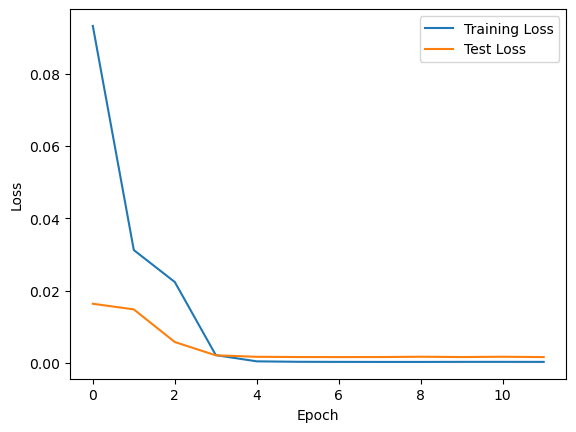

In [8]:
# plot the losses
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
model.eval()
test_predictions = []
with torch.inference_mode():
    for x, y in test_dataloader:
        x = x.to(device)
        output, (h_n, c_n) = model(x)
        test_predictions.extend(output.squeeze(dim=0).cpu().numpy())


test_close = [y[:, 0].cpu().numpy() for x, y in test_dataloader]
test_close = np.concatenate(test_close)

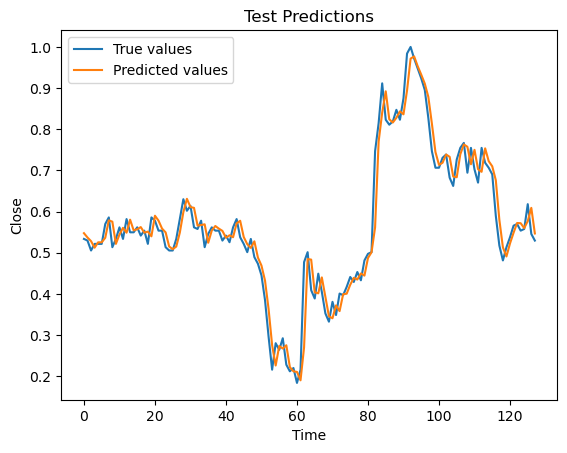

In [12]:
plt.plot(test_close, label='True values')
plt.plot(test_predictions, label='Predicted values')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('Test Predictions')
plt.legend()
plt.show()
